In [74]:
import numpy as np
import pandas as pd
import glob
import time
from scipy import signal
from tqdm.notebook import tqdm

from sklearn import ensemble
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc

import matplotlib.pyplot as plt                         
import matplotlib.patches as patches

import random

In [3]:
channels = ['Fz', 'FCz', 'Cz', 'CPz', 'Pz', 'POz']

train_filtered = np.load('data/X_train_bwbs.npy')

f = 'data/TrainLabels.csv'
train_labels = pd.read_csv(f)
train_labels = train_labels.Prediction.values

In [4]:
# Silence warning messages 
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

In [6]:
#Using SVM to find the optimal C in the dataset with baseline
# LDA SVM
C_list = [0.001,0.01,0.1,10]

opt_C = None
scaler = StandardScaler()
best_Cs = []

start = time.time()

for i in range(len(train_filtered[0])):
    x_train, x_test, y_train, y_test = train_test_split(train_filtered[:,i,:], train_labels, test_size=0.2)
    auc_best=0
    for c in C_list:
#         estimator = SVC(kernel = 'linear', max_iter=10000, probability=True, C = c)
#         parameter = {'kernel':('linear',), 'C':[c]}
#         grid_search = GridSearchCV(estimator, parameter, cv=5)
#         grid_search.fit(scaler.fit_transform(x_train), y_train)
#         pred_y = grid_search.predict(scaler.transform(x_test))
#         auc_score = roc_auc_score(y_test, pred_y)
        clf = make_pipeline(StandardScaler(), SVC(kernel = 'linear', max_iter=10000, probability=True, C = c))
        clf.fit(x_train, y_train)
        pred_y = clf.predict(x_test)
        auc_score = roc_auc_score(y_test, pred_y)
#         print('AUC:'+"{0:.3f}".format(auc_score))
        if auc_score > auc_best:
            auc_best = auc_score
            opt_C = c
    best_Cs.append(opt_C)

print('Time taken: {}'.format(time.time() - start))
for i in range(len(channels)):
    print('Best parameter C* for {} = {}'.format(channels[i], best_Cs[i]))

Time taken: 120.27875804901123
Best parameter C* for Fz = 0.001
Best parameter C* for FCz = 0.001
Best parameter C* for Cz = 10
Best parameter C* for CPz = 10
Best parameter C* for Pz = 10
Best parameter C* for POz = 0.001


In [7]:
c_values = best_Cs # from prev cell
start = time.time()

for i in range(len(c_values)):
    x_train, x_test, y_train, y_test = train_test_split(train_filtered[:,i,:], train_labels, test_size=0.2)
    estimator = SVC(kernel = 'linear', max_iter=10000, probability=True)
    parameter = {'kernel':('linear',), 'C':[c_values[i]]}
    grid_search = GridSearchCV(estimator, parameter, cv=5)
    grid_search.fit(scaler.fit_transform(x_train), y_train)
    pred_y = grid_search.predict(scaler.transform(x_test))
    auc_score = roc_auc_score(y_test, pred_y)
    print('{} electrode score: {}'.format(channels[i], auc_score))

Fz electrode score: 0.5
FCz electrode score: 0.5
Cz electrode score: 0.5061982544606642
CPz electrode score: 0.4895435802308683
Pz electrode score: 0.5798620025673942
POz electrode score: 0.5


In [8]:
# Fz electrode score: 0.497228405312354
# FCz electrode score: 0.5
# Cz electrode score: 0.5143310307070512
# CPz electrode score: 0.5053572310275021
# Pz electrode score: 0.5
# POz electrode score: 0.5107897013488649


for i in range(len(c_values)):
    x_train, x_test, y_train, y_test = train_test_split(train_filtered[:,i,:], train_labels, test_size=0.2)
    pred_y = [random.randint(0, 1) for i in range(len(y_test))]
    auc_score = roc_auc_score(y_test, pred_y)
    print('{} electrode score: {}'.format(channels[i], auc_score))

Fz electrode score: 0.4812666370444049
FCz electrode score: 0.509759040564834
Cz electrode score: 0.5071614583333334
CPz electrode score: 0.5104988961069903
Pz electrode score: 0.5225300421019038
POz electrode score: 0.4953825857519789


In [108]:
# Train our classifier
clfs = []
lda_types = ['lsqr (auto)', 'lsqr', 'svd']
ldas = {'lsqr (auto)': LinearDiscriminantAnalysis(solver = 'lsqr',  shrinkage = 'auto'),
        'lsqr': LinearDiscriminantAnalysis(solver = 'lsqr'),
        'svd': LinearDiscriminantAnalysis(solver = 'svd')}

for lda_type in lda_types:
    for i in range(len(c_values)):
        x_train, x_test, y_train, y_test = train_test_split(train_filtered[:,i,:], train_labels, test_size=0.2)
        clf_lsqrs = ldas[lda_type].fit(x_train, y_train)
        clfs.append(clf_lsqrs)
        # Let's do 5-fold cross validation
        score_lsqrs = cross_val_score(clf_lsqrs.fit(x_train, y_train), x_train, y_train, cv = 5)

        # We will print out the mean score
        print("solver = {}  accuracy: {}".format(lda_type, np.mean(score_lsqrs)))
    print()

solver = lsqr (auto)  accuracy: 0.7093294799213481
solver = lsqr (auto)  accuracy: 0.7146141969199096
solver = lsqr (auto)  accuracy: 0.70726130620109
solver = lsqr (auto)  accuracy: 0.7061124087783892
solver = lsqr (auto)  accuracy: 0.7054235454029587
solver = lsqr (auto)  accuracy: 0.7102484922865777

solver = lsqr  accuracy: 0.7070316850759465
solver = lsqr  accuracy: 0.6973799437824142
solver = lsqr  accuracy: 0.7003689773941962
solver = lsqr  accuracy: 0.6996780025601436
solver = lsqr  accuracy: 0.7010546735816936
solver = lsqr  accuracy: 0.7079448909299656

solver = svd  accuracy: 0.7065721788933318
solver = svd  accuracy: 0.7047338902305449
solver = svd  accuracy: 0.70542222574132
solver = svd  accuracy: 0.7031262784222125
solver = svd  accuracy: 0.7090988030668937
solver = svd  accuracy: 0.7095564617232142



In [73]:
# Test using classifier
lda_types = ['lsqr (auto)', 'lsqr', 'svd']
ldas = {'lsqr (auto)': LinearDiscriminantAnalysis(solver = 'lsqr',  shrinkage = 'auto'),
        'lsqr': LinearDiscriminantAnalysis(solver = 'lsqr'),
        'svd': LinearDiscriminantAnalysis(solver = 'svd')}

for lda_type in lda_types:
    average_score = 0
    for i in range(len(c_values)):
        x_train, x_test, y_train, y_test = train_test_split(train_filtered[:,i,:], train_labels, test_size=0.2)
        clf_lsqrs = ldas[lda_type].fit(x_train, y_train)
        # Let's do 5-fold cross validation
        score_lsqrs = cross_val_score(clf_lsqrs.fit(x_train, y_train), x_test, y_test, cv = 5)
        average_score += score_lsqrs
    average_score /= len(c_values)

    # We will print out the mean score
    print("solver = {} accuracy: {}".format(lda_type, np.mean(score_lsqrs)))

solver = lsqr (auto) accuracy: 0.6856677799856254
solver = lsqr accuracy: 0.6838202342197608
solver = svd accuracy: 0.7030862892656322


In [89]:
nfolds = 5;
cv = StratifiedKFold(n_splits = nfolds)
tprs_lsqrs = []
aucs_lsqrs = []
mean_fpr_lsqrs = np.linspace(0, 1, 100)

for i in range(len(c_values)):
    x_train, x_test, y_train, y_test = train_test_split(train_filtered[:,i,:], train_labels, test_size=0.2)
    X = x_train
    y = y_train
    temp_tprs_lsqrs, temp_aucs_lsqrs = [], []
    for train, test in cv.split(X, y):
        probas_lsqrs = clf_lsqrs.fit(X[train], y[train]).predict_proba(X[test])
        fpr_lsqrs, tpr_lsqrs, th_lsqrs = roc_curve(y[test], probas_lsqrs[:, 1])
        temp_tprs_lsqrs.append(np.interp(mean_fpr_lsqrs, fpr_lsqrs, tpr_lsqrs))
        temp_tprs_lsqrs[-1][0] = 0.0
        roc_auc_lsqrs = auc(fpr_lsqrs, tpr_lsqrs)
        temp_aucs_lsqrs.append(roc_auc_lsqrs)
    tprs_lsqrs.append(temp_tprs_lsqrs)
    aucs_lsqrs.append(temp_aucs_lsqrs)


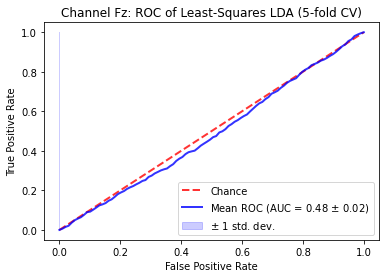

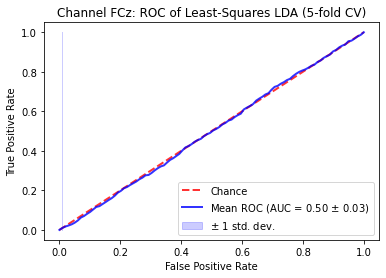

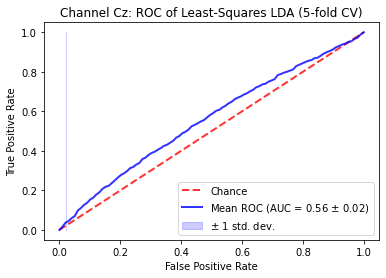

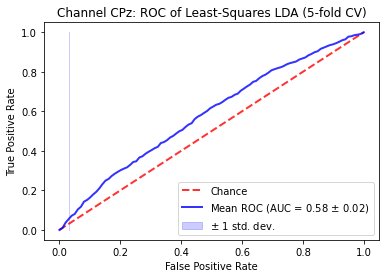

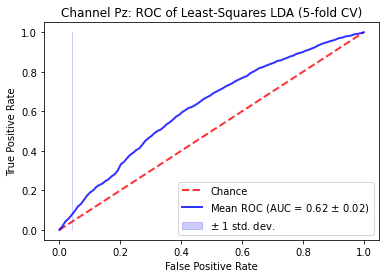

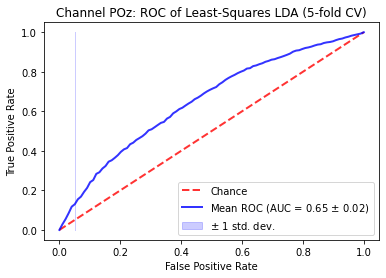

In [101]:
# Modified from:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

mean_tpr_lsqrs = [np.mean(x, axis=0) for x in tprs_lsqrs]
# mean_tpr_lsqrs[-1] = 1.0
mean_auc_lsqrs = [auc(mean_fpr_lsqrs, x) for x in mean_tpr_lsqrs]
std_auc_lsqrs = [np.std(x) for x in aucs_lsqrs]

for i in range(len(c_values)):
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.plot(mean_fpr_lsqrs, mean_tpr_lsqrs[i], color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_lsqrs[i], std_auc_lsqrs[i]),
             lw=2, alpha=.8)

    std_tpr_lsqrs = np.std(tprs_lsqrs[i], axis=0)
    tprs_upper_lsqrs = np.minimum(mean_tpr_lsqrs[i] + std_tpr_lsqrs[i], 1)
    tprs_lower_lsqrs = np.maximum(mean_tpr_lsqrs[i] - std_tpr_lsqrs[i], 0)
    plt.fill_between(mean_fpr_lsqrs[i], tprs_lower_lsqrs, tprs_upper_lsqrs, color='b', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Channel ' + channels[i] + ': ROC of Least-Squares LDA (' + str(nfolds) + '-fold CV)')
    plt.legend(loc="lower right")
    plt.show()

In [102]:
# Set clf to clf_lsqrs for convenience
clf = clf_lsqrs.fit(x_train, y)

# Make predictions on our dataset 
conf = clf.decision_function(x_test) # predicted confidence score
pred = clf.predict(x_test)           # predicted label (we won't actually use this)

auc_score = roc_auc_score(y_test, pred)
print(auc_score)

0.5392086429785613


In [105]:
def plot_roc(y, preds, model):
    fpr, tpr, thresholds = roc_curve(y, preds)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Optimal threshold: ", optimal_threshold)
    l1, = plt.plot([0, 1], [0, 1], '--')
    l2, = plt.plot(fpr, tpr, label = 'Random Forest')
    auc = roc_auc_score(y, preds)
    l = plt.legend([l2], [model+str(' AUC: %.2f' % auc)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

Optimal threshold:  0.6868441140024737


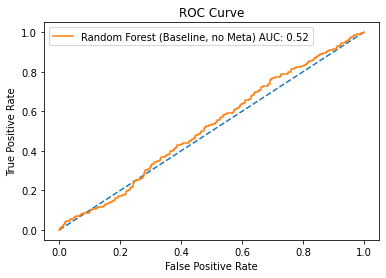

Optimal threshold:  0.7168546881134625


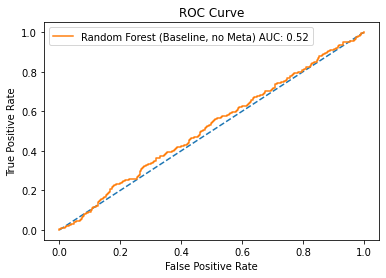

Optimal threshold:  0.7364586777549268


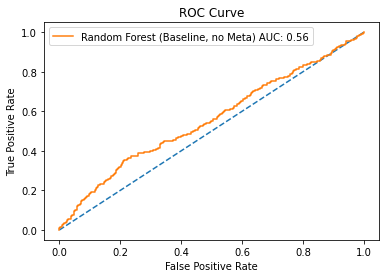

Optimal threshold:  0.677630043278181


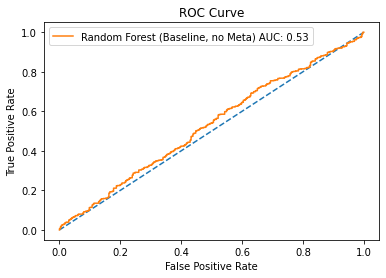

Optimal threshold:  0.6955032559110648


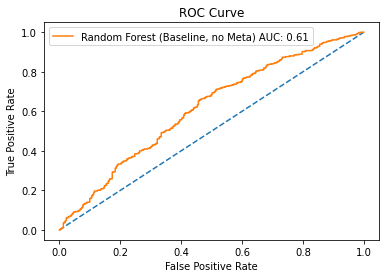

Optimal threshold:  0.7234027862054828


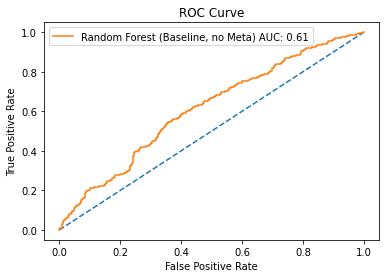

In [106]:
clf = ensemble.RandomForestClassifier(n_jobs = -1, n_estimators=500, min_samples_split=10,
                                      min_samples_leaf=4, max_depth = 10, random_state=42)

for i in range(len(c_values)):
    x_train, x_test, y_train, y_test = train_test_split(train_filtered[:,i,:], train_labels, test_size=0.2)
    clf.fit(x_train, y_train)
    preds = clf.predict_proba(x_test)[:,1]
    plot_roc(y_test, preds, 'Random Forest (Baseline, no Meta)')